# CS 369 2019 


Student: Jack Goodson

UPI: JGOO420


## Assignment 4 : HMM & MCMC (13 + 2 points)


In this assignment you will write code to implement
- The forward and backward algorithms for hidden Markov models, 
- The MCMC algorithm to sample the posterior distribution. 

Plus 2 extra points for well commented code.

Due: Wednesday 12th June at 23:59 


### Instruction

Please update your name and UPI above.  

Write your submission in a Jupyter notebook and write any code in Python 3. You should submit the .ipynb file. The primary document the markers will look at is the .ipynb file.

In your report, include explanations of what you are doing and comments in the code. Where you are making mathematical derivations, show your working.


In [4]:
from platform import python_version
print("python", python_version())

import numpy as np
print("numpy", np.version.version)

import pandas 
print("pandas", pandas.__version__)

import matplotlib
print("matplotlib", matplotlib.__version__)

import scipy.stats
print("scipy", scipy.version.version)

import math 
print("math", hasattr(math, "isfinite"))

%matplotlib inline
import matplotlib.pyplot as plt

python 3.7.1
numpy 1.15.4
pandas 0.23.4
matplotlib 3.0.2
scipy 1.1.0
math True


## Question 1 HMM

In Assignment 2, we introduced a simple HMM to model secondary structure in proteins with states $H,S,T$ and symbols $B,I,N$. Refer to that assignment for more detail about the model and its meaning. It has :

transition probabilities __a__ = 

$$
\begin{pmatrix}
 & H & S & T\\
H & 0.95 & 0.01 & 0.04\\
S & 0.0333 & 0.9167 & 0.05\\
T & 0.05 & 0.05 & 0.90
\end{pmatrix}
$$

and emission probabilites __e__ =

$$
\begin{pmatrix}
 & B & I & N\\
H & 0.35 & 0.55 & 0.10 \\
S & 0.55 & 0.15 & 0.30 \\
T & 0.10 & 0.10 & 0.80
\end{pmatrix}
$$


### i.  Simulate a HMM (2 points)

Write a function `simulate_HMM` to simulate a state and symbol sequence pair ($\pi$,$x$) of length 100. Print $\pi$ and $x$ to output. Make sure that $\pi$ has at least two runs of $H$s (you can set the random seed using `numpy.random.seed()` until you are happy with your sequence). You will use this simulated pair for the remainder of this question.

In [5]:
np.random.seed(1234)
def simulate_HMM(a, e, n, s):
    emission_list = [] # emission list, ie; BINNINBINBINBNI...
    transition_list = [] # transition list, ie; SHSTHSHTSHTHSTH...
    curr_pos = s # starting for transitions
    for i in range(n):
        em = e[:][curr_pos:curr_pos] # index emission matrix with current transition symbol
        trans = a[:][curr_pos:curr_pos] # index transition matrix with current symbom
        emission_state = np.random.choice(['B','I','N'], p=em.values[0]) # generate random weighted emission
        transition_state = np.random.choice(['H','S','T'], p=trans.values[0]) # generate random weighted transition
        emission_list.append(emission_state) # add emission to emission list
        transition_list.append(curr_pos) # add transtion to transition list
        curr_pos = transition_state # set current position to new transition state
    return "".join(transition_list), "".join(emission_list) # return emissions and transitions as strings

In [6]:
np.random.seed(1234)

e_frame = np.reshape((0.35,0.55,0.10,0.55,0.15,0.30,0.10,0.10,0.80), (3, 3)) # emission matrix
emission = pandas.DataFrame(e_frame, index=['H','S','T'], columns=['B','I','N']) # index emission matrix

t_frame = np.reshape((0.95,0.01,0.04,0.0333,0.9167,0.05,0.05,0.05,0.90), (3, 3)) # transition matrix
transition = pandas.DataFrame(t_frame, index=['H','S','T'], columns=['H','S','T']) # index transtion matrix

sequences = simulate_HMM(transition, emission, 100, "H") # generate sequences
print(sequences)

('HHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTSTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTSSSSSSSSSSSSSSSSSSSSTTTTTTTTHHHHHHH', 'BIIBNIIIIIIBNIBIIIBIBBIBBBIIINNNNBINNNNBNNNNNINNNBNNNBINNNNNNNNNBBNBNBBNBNINBNNIBNNBNNNNNNNNNIIIBBII')


### ii. The forward algorithm (2 points)

Write a function to implement the forward algorithm to return a forward table matrix $F$ and the probability $P(x)$ of the observing sequence $x$. You need to print $P(x)$ and make explicit if it is in a log space. $x$ is simulated by Question i. For forward algorithm examples, see Lecture 16 & Tutorial 6. 


In [7]:
np.random.seed(21)

def forward_matrix(a, e):
    seq = sequences[1] # get emission sequence
    mat = np.zeros([3, len(seq)],dtype = float) # generate matrix for length of sequence list
    mat = pandas.DataFrame(mat, index = ['H','S','T']) # index matrix
    a, e = np.log(a), np.log(e) # log transition and emission matrixs
    for x in range(len(seq)): # run for length of sequence
        if x == 0: # initial condition of forward matrix
            mat[0]["H"] = np.log(1/3) + e[seq[x]]["H"] # 1/3 probability + emission probability with given transition
            mat[0]["S"] = np.log(1/3) + e[seq[x]]["S"]
            mat[0]["T"] = np.log(1/3) + e[seq[x]]["T"]
        else:
            # perform forward algorithm until we reach the end of the sequence
            mat[x]["H"] = e[seq[x]]["H"] + np.log(np.exp(mat[x-1]["H"] + a["H"]["H"]) + np.exp(mat[x-1]["S"] + a["H"]["S"]) + np.exp(mat[x-1]["T"] + a["H"]["T"]))
            mat[x]["S"] = e[seq[x]]["S"] + np.log(np.exp(mat[x-1]["H"] + a["S"]["H"]) + np.exp(mat[x-1]["S"] + a["S"]["S"]) + np.exp(mat[x-1]["T"] + a["S"]["T"]))
            mat[x]["T"] = e[seq[x]]["T"] + np.log(np.exp(mat[x-1]["H"] + a["T"]["H"]) + np.exp(mat[x-1]["S"] + a["T"]["S"]) + np.exp(mat[x-1]["T"] + a["T"]["T"]))
    n = len(seq) -1 # get values as end of new formward matrix
    val = np.log(np.exp(mat[n]["H"]) + np.exp(mat[n]["S"]) + np.exp(mat[n]["T"])) # calculate P(x) for forward matrix       
    return mat, val

vals = forward_matrix(transition, emission)

print("Probability in log space is:", vals[1])

Probability in log space is: -91.23449679545665


### iii. The backward algorithm (2 points)

Write a function to implement the backward algorithm to return a matrix $B$ and the probability $P(x)$ of the observing sequence $x$. You need to print $P(x)$ and make explicit if it is in a log space. $x$ is simulated by Question i. For a backwards algorithm example, see Tutorial 6. 


In [8]:
def backward_matrix(a, e):
    pandas.options.mode.chained_assignment = None
    seq = sequences[1] # get emission sequence
    n = len(seq)
    mat = np.zeros([3, len(seq)],dtype = float) # generate matrix for length of sequence list
    mat = pandas.DataFrame(mat, index = ['H','S','T']) # index matrix
    a, e = np.log(a), np.log(e) # log transition and emission matrixs
    for x in range(len(seq), 0, -1): # go from end of sequence to start
        if x == n: # initial condition for backward matrix
            mat[len(seq)] = 0 # end of matrix set to 0
        else:
            # perform backward algorithm on matrix from back to front
            e_val = seq[x] # get value at point in sequence
            mat[x]["H"] = np.log(np.exp(a["H"]["H"] + e[e_val]["H"] + mat[x+1]["H"]) + np.exp(a["S"]["H"] + e[e_val]["S"] + mat[x+1]["S"]) + np.exp(a["T"]["H"] + e[e_val]["T"] + mat[x+1]["T"]))
            mat[x]["S"] = np.log(np.exp(a["H"]["S"] + e[e_val]["H"] + mat[x+1]["H"]) + np.exp(a["S"]["S"] + e[e_val]["S"] + mat[x+1]["S"]) + np.exp(a["T"]["S"] + e[e_val]["T"] + mat[x+1]["T"]))
            mat[x]["T"] = np.log(np.exp(a["H"]["T"] + e[e_val]["H"] + mat[x+1]["H"]) + np.exp(a["S"]["T"] + e[e_val]["S"] + mat[x+1]["S"]) + np.exp(a["T"]["T"] + e[e_val]["T"] + mat[x+1]["T"]))
    e_val = seq[0] # get value at start of sequence
    prob = np.exp(e[e_val]["H"] + mat[1]["H"] + np.log(1/3)) + np.exp(e[e_val]["S"] + mat[1]["S"] + np.log(1/3)) + np.exp(e[e_val]["T"] + mat[1]["T"] + np.log(1/3)) # calucate "top left" value of matrix
    mat = mat.drop(columns = 0) # delete first column
    mat.columns = range(0, n) # re-index columns
    return mat, np.log(prob)
vals = backward_matrix(transition, emission)
print("Probability in log space is:", vals[1])

Probability in log space is: -91.23449679545655


### iv. Test (1 point)

Calculate the matrix __P__ where the ($k,i$)th entry of __P__ is $P(k, i) = Pr(\pi_i = k|x)$, the posterior probability of being in state $k$ at step $i$. Notice that $P(k, i)$ is not a log probability in the below equation. $F(k, i)$ and $B(k, i)$ are from the anwsers of above questions.  

$P(k,i) = Pr(\pi_i = k | x) = \frac{F_i(k)B_i(k)}{P(x)}$

Print the matrix __P__, and show that your method is correct by checking the column sums of __P__ are all 1.


In [9]:
# multply values of the two matrixs and divide by P(x)
mult_mat = (np.exp(forward_matrix(transition, emission)[0]) * np.exp(backward_matrix(transition, emission)[0])) / np.exp(backward_matrix(transition, emission)[1])
#take the sum of the sums of all the columns, this is 100 as the sequence length is 100
print("Sum of columns from multiplied and divided matrix summed", round(np.sum(mult_mat.sum(axis=0)), 8))

Sum of columns from multiplied and divided matrix summed 100.0


### v. Plot (1 point)

Make a plot of $Pr(\pi_i = H|x)$ against the index $i$ (that is, plot $i$ on the horizontal axis and $Pr(\pi_i = H|x)$ on the vertical axis). To embed the plot in your report, include in the first cell of your notebook the command `%matplotlib inline`

HHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTSTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTSSSSSSSSSSSSSSSSSSSSTTTTTTTTHHHHHHH


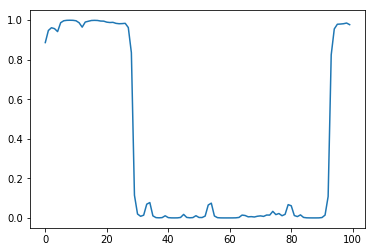

In [10]:
plt.plot(range(0, len(sequences[1])), mult_mat.iloc[0]) # plot our multiplied matrixs together
print(sequences[0])

### vi. Report (1 point)

By comparing your plot to the true state sequence $\pi$, discuss whether or not you think you could accurately find the $\alpha$-helices in a given protein sequence using this model.

Looking at our true sequence and our graph, it seems that we can fairly accurately predict where $\alpha$-helices will occur in the sequence, with the graph rising at about the same positions as where we see H's in our sequence and lowering where we do not

## Question 2 MCMC

### i. Write a method (1 points)

Implement an MCMC algorithm to sample the posterior distribution of the effective population size $N_e$ given the 10-taxa tree simulated by _Simulation.py_ (available on Canvas). The proposal kernel should be a uniform random walk on the parameter $N_e$, so that $\delta \sim Unif(-10, 10)$ and $N_e' = N_e + \delta$. The lower boundary of zero can be treated by reflection or rejection. The target distribution is the coalescent likelihood:

$$ p(T|N_e) = \prod^n_{k=2}\Big( \frac{1}{N_e} exp\Big( − \frac{k(k−1)t_k}{2N_e} \Big) \Big) $$

where $t_k$ is the time duration that the tree $T$ has $k$ lineages.


You may find that you need to calculation this target distribution in log space to avoid numerical underflow:


$$ ln(p(T|N_e)) = \sum^n_{k=2}\Big( - ln(N_e) − \frac{k(k−1)t_k}{2N_e} \Big) $$


The the acceptance probability will be:
􏰑

$ \alpha = min 􏰉( 1, exp (p2 - p1) ) $, where
proposal state $p2 = ln (p(N_e'|T))$ and 
current state $p1 = ln (p(N_e|T))$


Notice above I gave you the coalescent likelihood, $p(T|N_e)$, not the posterior $p(N_e|T)$, so you need to also define a prior $p(N_e)$ to compute the posterior (up to a constant). If you only use the coalescent likelihood as the target distribution you will be effectively using an (improper) uniform prior. Something like a diffuse log-normal makes a lot more sense.

You may test your method by printing out the "important" parameters in each state with a short-length run.

If the above equations are not displayed properly, you can see them from the attached png files.


simulate a coalescent tree with 10 tips and Ne =  100


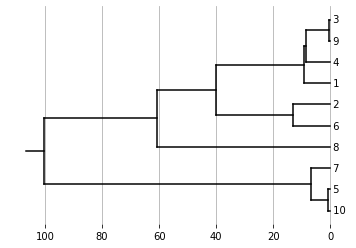

the plotted tree height is 100.440


In [11]:
%matplotlib inline
# Note: the given Python classes are imported successfully only when the plotted tree is shown below, 
# otherwise please run this cell again.   
%run Simulation.py

n,Ne=10,100
print("simulate a coalescent tree with", n, "tips and Ne = ", Ne)

np.random.seed(1234)
tree = coalescent(n,Ne)
plot_tree(tree)
print("the plotted tree height is {:.3f}".format(tree.get_root().get_height()))

In [12]:
def tk_visit(node, time_list): # function to traverse our tree
    if(node.get_height() != 0):
        time_list.append(node.get_height()) # get height of child we're visitings
    for c in range(len(node.get_children())): # visit all the children of the children recursively
        tk_visit(node.get_children()[c], time_list)
    return time_list

heights = tk_visit(tree.get_root(), [])
heights.sort(reverse = True) # sort heights from tree traversal
tk = []
for i in range(len(heights) - 1):
    tk.append(heights[i] - heights[i + 1]) # get lineage times from preceeding nodes
tk.append(heights[-1]) # get last node height

In [13]:
def l_hood(n, tk, Ne):
    sums = []
    for k in range(2, n + 1): # k starts at 2 
        part1 = -np.log(Ne) # get part 1 of equation
        part2 = -(k*(k - 1) * tk[k - 2]) / (2 * Ne) # get part 2 of equation
        total = part1 + part2 # add together 
        sums.append(total)
    return np.sum(sums) # return log probability of target distribution liklihood


def l_norm(x, m, s): #function for log normal distribution 
    l1 = (x * s * np.sqrt(2*np.pi)) # part 1 of denomenator 
    l2 = np.exp(- (np.log(x) - m) ** 2 / (2*s**2))# part 2 of denomenator 
    return 1 /  l1 * l2 # final number


def MCMC(Ne, mean, sd, trials):
    posts = [] # posterior distribution data list

    for i in range(trials): # run for specified amount of trials
        Ne_prime = Ne + np.random.uniform(-10, 10) # generate Ne` with random uniform sample
        p1 = l_hood(n, tk, Ne) + np.log(l_norm(Ne, mean, sd)) # generate p1
        p2 = l_hood(n, tk, Ne_prime) + np.log(l_norm(Ne_prime, mean, sd)) # generate p2
        if np.random.uniform(0,1) < min(1, np.exp(p2-p1)): # if min of 1 and exp(p2-p1) < a random number
            Ne = Ne_prime # we take Ne` as our new Ne
        posts.append(Ne) # add Ne to our data
        
    return posts

### ii. Plot and report (3 points)

Give a starting value $N_e = 100$, and run a MCMC with the chain of length 10,000 steps:

1. Plot the posterior distribution of $N_e$ simpled from your MCMC run. 

2. Plot the prior distribution, and report what prior you used.

3. Compare 1 and 2 to comment on how you would get a better estimate of the effective population size.

Posterior distribution


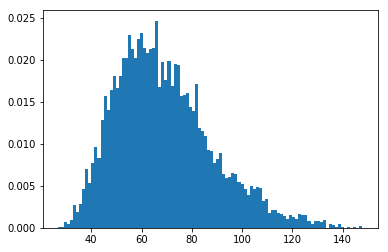

In [14]:
print("Posterior distribution")
mean, sd = np.log(75), 0.5 # prior estimations
d = MCMC(Ne, mean, sd, 10000) # simulate 10000 trials 
plt.hist(d, bins = 100, density = True);

Prior distribution


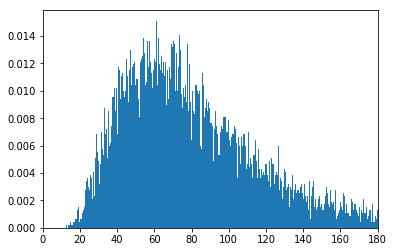

In [15]:
# simulate 10000 samples from a log normal distribution with our prior values
plt.hist(np.random.lognormal(mean, sd, 10000), bins = 1000, density = True)
ax = plt.gca()
print("Prior distribution")
ax.set_xlim(0,180);

Looking at our plots we could improve our estimate of the population size by getting more data on what is being sampled so we can better estimate our population mean and standard distribution. The estimates I chose of 75 and 0.5 were based on what we knew (we knew Ne = 100 but would be cheating a bit if we used that) and the standard distribution was a guess that was changed after running the MCMC a few times and finding something similar. If we had some more "biological" information about the tree we were estimating our initial estimates might be better to, I assume the population sizes and standard distributions between elephants and bacterium for example differ quite significantly, this information wasn't known to us.

#

#